In [161]:
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # optional
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

In [255]:
# ### Load data (one file)
# file = "../data/onetrack_multicluster/pion_files/001.npy"
# event_data = np.load(file, allow_pickle=True).item()
# df = pd.DataFrame(event_data)

In [200]:
### Load data (multiple files)
n_files = 100
files = glob.glob("../data/onetrack_multicluster/pion_files/*.npy")
df = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files[:n_files])])

100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


In [322]:
pd.DataFrame(df.cluster_E.to_list()).shape

(1027650, 35)

In [358]:
### Start the dataframe of inputs 
# df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list())[0]) # just take the leading cluster E 
df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list(), columns=["cluster_e_"+str(x) for x in np.arange(35)])) # just take the leading cluster E 
# df2 = df2.rename(columns={0: 'cluster_e'})

### Add track pT & truth particle E 
track_pt = np.array(df.trackPt.explode())
truth_particle_e = np.array(df.truthPartE.explode())
df2["track_pt"] = track_pt
df2["truth_particle_e"] = truth_particle_e

### Drop NaNs 
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
# df2 = df2.dropna()
df2 = df2.fillna(0)

### Cluster_E > 0.5
df2 = df2[df2.cluster_e_0 > 0.5]

### Lose outliers in track pT 
df2 = df2[df2.track_pt < 5000]

### Cast as float
df2 = df2.astype('float32')

### Add the log of all variables
for var in df2.keys():
    df2['log10_'+var] = np.log10(df2[var])
    
### Do this again? 
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df2 = df2.fillna(0)

/clusterfs/ml4hep/mpettee/miniconda3/envs/nbdev/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


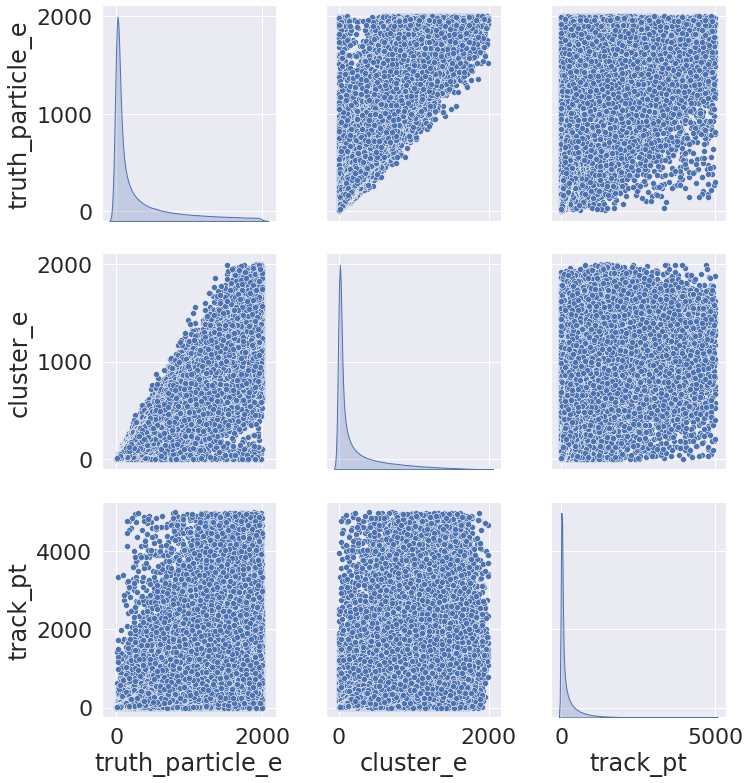

In [300]:
### Inspect variables 
sns.set(font_scale = 2)
g = sns.pairplot(df2[['truth_particle_e', 'cluster_e', 'track_pt']], diag_kind='kde')
g.fig.set_figheight(12)
g.fig.set_figwidth(12)

In [359]:
### Test/train split 
train = df2.sample(frac=0.8, random_state=0)
test = df2.drop(train.index)

# train_vars = [
#     'log10_cluster_e', 
#     'log10_track_pt'
#              ]

train_vars = [var for var in df2.keys() if var.startswith('log10') and var != 'log10_truth_particle_e']

train_x = train[train_vars].values
train_y = train['log10_truth_particle_e'].values
test_x = test[train_vars].values
test_y = test['log10_truth_particle_e'].values

In [360]:
### Normalize the inputs 
sc = StandardScaler()
train_x = sc.fit_transform(train_x)
test_x = sc.transform(test_x)

In [367]:
def regression_model():
    model = Sequential()
    model.add(Dense(50, input_dim=train_x.shape[1], activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [368]:
model = regression_model()
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 50)                1850      
_________________________________________________________________
dense_59 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_60 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 51        
Total params: 7,001
Trainable params: 7,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
history = model.fit(
    train_x,
    train_y,
    validation_split=0.2,
    verbose=1, epochs=15)

Epoch 1/15
11592/20082 [================>.............] - ETA: 16s - loss: 0.0821

In [ ]:
### Evaluate performance on test set 
test['nn_score'] = model.predict(test_x)
plt.hist(test.log10_truth_particle_e/test.nn_score, bins=np.linspace(0,2,40));

In [ ]:
### Response median plot 
import scipy.stats as stats
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm

x = test.truth_particle_e
y = test.nn_score/test.log10_truth_particle_e

xbin = [10**exp for exp in np.arange(-1., 3.1, 0.05)]
ybin = np.arange(0., 3.1, 0.05)
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
profileXMed = stats.binned_statistic(
    x, y, bins=xbin, statistic='median').statistic

c_map = ListedColormap(sns.color_palette("Blues", n_colors=100).as_hex())
fig = plt.figure(figsize=(12,8))
fig.patch.set_facecolor('white')
plt.hist2d(x, y, bins=[xbin, ybin], norm=LogNorm(),zorder = -1, cmap=c_map);
plt.plot(np.array(xcenter), np.array(profileXMed), color='indianred', linewidth=3)
plt.plot([0.1, 1000], [1, 1], linestyle='--', color='black');
plt.xscale('log')
plt.ylim(0, 1.75)
plt.xlim(0.3, )
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Predicted Energy / Target');

In [ ]:
### IQR plot 

def iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q84, q16 = np.percentile(x, [84, 16])
    iqr = q84 - q16
    med = np.median(x)
    return iqr / (2*med)

resolution = stats.binned_statistic(x, y, bins=xbin,statistic=iqrOverMed).statistic

fig = plt.figure(figsize=(10,6))
fig.patch.set_facecolor('white')
plt.plot(xcenter, resolution, linewidth=3)
plt.xscale('log')
plt.xlim(0.1, 1000)
plt.ylim(0,0.5)
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Response IQR / 2 x Median');